## Classification and Regression Trees

This chapter describes a flexible data-driven method that can be used for both classification (called *classification tree*) and prediction (called *regression tree*). Among the data-driven methods, trees are the most transparent and easy to interpret. Trees are based on separating records into subgroups by  creating splits on predictors. These splits create logical rules that are transparent and easily understandable, for example, "IF Age < 55 AND Education > 12 THEN class = 1". The resulting subgroups should be more homogeneous in terms of the outcome variable, thereby creating useful prediction or classification rules. We discuss the two key ideas underlying trees: *recursive partitioning* (for constructing the tree) and *pruning* (for cutting the tree back). In the context of tree construction, we also describe a few metrics of homogeneity that are popular in tree algorithms, for determining the homogeneity of the resulting subgroups of records. We explain that limiting tree size is a useful strategy for avoiding overfitting and show how it is done. We also describe alternative strategies for avoiding overfitting. As with other data-driven methods, trees require large amounts of data. However, once constructed, they are computationally cheap to deploy even on large samples. They also have other advantages such as being highly automated, robust to outliers, and able to handle missing values. In addition to prediction and classification, we describe how trees can be used for dimension reduction. Finally, we introduce *random forests* and *boosted trees*, which combine results from multiple trees to improve predictive power.

## Imports

In this chapter, we will use pandas for data handling, scikit-learn for the models, and matplotlib and pydotplus for visualization. We will also make use of the utility functions from the Python Utilities Functions Appendix. Use the following import statements for the Python code in this chapter.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from dmutils import plot_decision_tree
from dmutils import classification_summary, regression_summary

## Introduction

If one had to choose a classification technique that performs well across a wide range of situations without requiring much effort from the analyst while being readily understandable by the consumer of the analysis, a strong contender would be the tree methodology developed by Breiman et al. (1984). We discuss this classification procedure first, then in later sections we show how the procedure can be extended to prediction of a numerical outcome. The program that Breiman et al. created to implement these procedures was called CART (Classification And Regression Trees). A related procedure is called C4.5.

What is a classification tree? The figure below shows a tree for classifying bank customers who receive a loan
offer as either acceptors or nonacceptors, based on information such as their income, education level,
and average credit card expenditure.

![title](../images/example-of-tree-classifying-bank-customers-as-loan-acceptors-or-non-acceptors.png)

### Tree Structure

We have two types of nodes in a tree: decision (=splitting) nodes and terminal nodes. Nodes that have successors are called *decision nodes* because if we were to use a tree to classify a new record for which we knew only the values of the predictor variables, we would "drop" the record down the tree so that at each decision node, the appropriate branch is taken until we get to a node that has no successors. Such nodes are called the *terminal nodes* (or *leaves* of the tree), and represent the partitioning of the data by predictors.

It is useful to note that the type of trees grown by Python's `DecisionTreeClassifier()` method, also known as CART or *binary trees*, have the property that the number of terminal nodes is exactly one more than the number of decision nodes. When using the `export_graphviz()` function from `scikit-learn`, nodes are represented as boxes. The
function has a large number of arguments that allow controlling the final graph. We use the utility function `plotDecisionTree` from the utility module for plotting the graphs in this chapter. With the chosen settings, all nodes contain information about the number of records in that node (samples), the distribution of the classes, and the majority class of that node. In addition, we color the nodes by the average value of the node for regression or purity of node for classification.

For decision nodes, the name of the predictor variable chosen for splitting and its splitting value appear at the top. Of the two child nodes connected below a decision node, the left box is for records that meet the splitting condition ("True"), while the right box is for records that do not meet it ("False").

### Decision Rules

One of the reasons that tree classifiers are very popular is that they provide easily understandable decision rules (at least if the trees are not too large). Consider the tree in the example. The *terminal* odes are colored orange or blue corresponding to a nonacceptor (0) or acceptor (1) classification. The condition at the top of each splitting node gives the predictor and its splitting value for the split (e.g. *Income* ≤ 110.5 in the top node). *samples=* shows the number of records in that node, and *values=* shows the counts of the two classes (0 and 1) in that node; the labels are only shown in the top node. This tree can easily be translated into a set of rules for classifying a bank customer. For example, the bottom-left node under the "Family" decision node in this tree gives us the following rule:

    IF(Income > 110.5) AND (Education ≤ 1.5) AND (Family ≤ 2.5)
    THEN Class = 0 (nonacceptor).

### Classifying a New Record

To classify a new record, it is "dropped" down the tree. When it has dropped all the way down to a terminal node, we can assign its class simply by taking a "vote" (or average, if the outcome is numerical) of all the training data that belonged to the terminal node when the tree was grown. The class with the highest vote is assigned to the new record. For instance, a new record reaching the leftmost terminal node in above figure, which has a majority of records that belong to the 0 class, would be classified as "nonacceptor". Alternatively, we can convert the number of class 0 records in the node to a proportion (propensity) and then compare the proportion to a user-specified cutoff value. In a binary classification situation (typically, with a success class that is relatively rare and of particular interest), we can also establish a lower cutoff to better capture those rare successes (at the cost of lumping in more failures as successes). With a lower cutoff, the votes for the *success* class only need attain that lower cutoff level for the entire terminal node to be classified as a *success*. The cutoff therefore determines the proportion of votes needed for determining the terminal node class. See [Evaluating Predictive Performance](evaluating-predictive-performance.ipynb) for further discussion of the use of a cutoff value in classification, for cases where a single class is of interest.

In the following sections, we show how trees are constructed and evaluated.

## Classification Trees

The key idea underlying tree construction is recursive partitioning of the space of the predictor variables. A second important issue is avoiding over-fitting. We start by explaining recursive partitioning and then describe approaches for evaluating and fine-tuning trees while avoiding overfitting.

### Recursive Partitioning

Let us denote the outcome variable by $Y$ and the input (predictor) variables by $X_1$, $X_2$, $X_3$, ..., $X_p$. In
classification, the outcome variable will be a categorical variable. Recursive partitioning divides up the *p*-dimensional space of the $X$ predictor variables into nonoverlapping multidimensional rectangles. The predictor variables here are considered to be continuous, binary, or ordinal. This division is accomplished recursively (i.e., operating on the results of prior divisions). First, one of the predictor variables is selected, say $X_i$, and a value of $X_i$, say $s_i$, is chosen to split the *p*-dimensional space into two parts: one part that contains all the points with $X_i$ < $s_i$ and the other with all the points with $X_i$ ⩾ $s_i$. Then, one of these two parts is divided in a similar manner by again choosing a predictor variable (it could be $X_i$ or another variable) and a split value for that variable. This results in three (multidimensional) rectangular regions. This process is continued so that we get smaller and smaller rectangular regions. The idea is to divide the entire $X$-space up into rectangles such that each rectangle is as homogeneous or "pure" as possible. By *pure*, we mean containing records that belong to just one class. (Of course, this is not always possible, as there may be records that belong to different classes but have exactly the same values for every one of the predictor variables.

Let us illustrate recursive partitioning with an example.

### Example 1: Riding Mowers

We again use the riding-mower example presented in [Data Visualization](data-visualization.ipynb) A riding-mower manufacturer would like to find a way of classifying families in a city into those likely to purchase a riding mower and those not likely to buy one. A pilot random sample of 12 owners and 12 nonowners in the city is undertaken. The data are shown and plotted below.

In [2]:
mower_df = pd.read_csv("../datasets/RidingMowers.csv")
mower_df

,Income,Lot_Size,Ownership
0,60.0,18.4,Owner
1,85.5,16.8,Owner
2,64.8,21.6,Owner
3,61.5,20.8,Owner
4,87.0,23.6,Owner
5,110.1,19.2,Owner
6,108.0,17.6,Owner
7,82.8,22.4,Owner
8,69.0,20.0,Owner
9,93.0,20.8,Owner


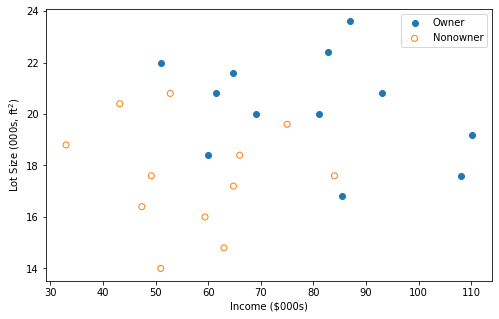

In [3]:
# plot first the data points for Ownership equals "Owner" and then of "Nonowner"
# setting color to "none" gives open circles

_, ax = plt.subplots(figsize=(8, 5))
for cat_value, color in [("Owner", "C0"), ("Nonowner", "C1")]:
    subset_df = mower_df[mower_df.Ownership == cat_value]
    if color == "C1":
        _color = "none"
    else:
        _color = color
    ax.scatter(subset_df.Income, subset_df.Lot_Size, color=_color,
               edgecolor=color, marker="o", label=cat_value)

ax.legend()
ax.set_xlabel("Income ($000s)")
ax.set_ylabel("Lot Size (000s, ft$^2$)")
plt.show()

If we apply the classification tree procedure to these data, the procedure will choose Income for the first split with a splitting value of 60. The ($X_1$, $X_2$) space is now divided into two rectangles, one with Income ≤ 59.7 and the other with Income > 59.7. This is illustrated next:

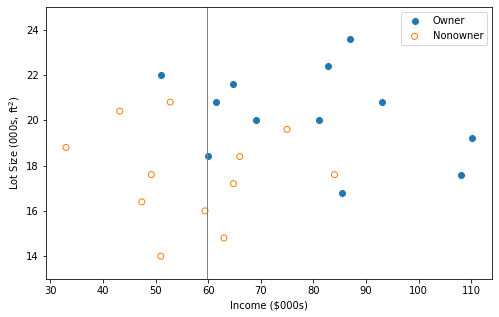

In [4]:
# plot first the data points for Ownership equals "Owner" and then of "Nonowner"
# setting color to "none" gives open circles

_, ax = plt.subplots(figsize=(8, 5))
for cat_value, color in [("Owner", "C0"), ("Nonowner", "C1")]:
    subset_df = mower_df[mower_df.Ownership == cat_value]
    if color == "C1":
        _color = "none"
    else:
        _color = color
    ax.scatter(subset_df.Income, subset_df.Lot_Size, color=_color,
               edgecolor=color, marker="o", label=cat_value)

ax.plot([59.7, 59.7], [13, 25], linewidth=1, color="gray")
ax.legend()
ax.set_xlabel("Income ($000s)")
ax.set_ylabel("Lot Size (000s, ft$^2$)")
ax.set_ylim([13, 25])
plt.show()

Notice how the split has created two rectangles, each of which is much more homogeneous than the rectangle before the split. The left rectangle contains points that are mostly nonowners (7 nonowners and 1 owner) and the right rectangle contains mostly owners (11 owners and 5 nonowners).

How was this particular split selected? The algorithm examined each predictor variable (in this case, Income and Lot Size) and all possible split values for each variable to find the best split. What are the possible split values for a variable? They are simply the midpoints between pairs of consecutive values for the predictor. The possible split points for Income are {38.1, 45.3, 50.1, ..., 109.5} and those for Lot Size are {14.4, 15.4, 16.2, ..., 23}. These split points are ranked according to how much they reduce impurity (heterogeneity) in the resulting rectangle. A pure rectangle is one that is composed of a single class (e.g., owners). The reduction in impurity is defined as overall impurity before the split minus the sum of the impurities for the two rectangles that result from a split.

### Categorical Predictors

The previous description used numerical predictors; however, categorical predictors can also be used in the recursive partitioning context. To handle categorical predictors, the split choices for a categorical predictor are all ways in which the set of categories can be divided into two subsets. For example, a categorical variable with four categories, say {a, b, c, d}, can be split in seven ways into two subsets: {a} and {b, c, d}; {b} and {a, c, d}; {c} and {a, b, d}; {d} and {a, b, c}; {a, b} and {c, d}; {a, c} and {b, d}; and finally {a, d} and {b, c}. When the number of categories is large, the number of splits becomes very large. As with *k*-nearest-neighbors, a predictor with *m* categories (*m* > 2) should be factored into *m* dummies (not *m* - 1).

### Normalization

Whether predictors are numerical or categorical, it does not make any difference if they are standardized (normalized) or not.

### Measure of Impurity

There are a number of ways to measure impurity. The two most popular measures are the *Gini index* and an entropy measure. We describe both next. Denote the *m* classes of the response variable by *k* = 1, 2, ..., *m*.

The Gini impurity index for a rectangle *A* is defined by:

<p style="text-align:center">
    $I(A) = 1 - \sum \limits _{k=1}^{m} p^{2}_{k}$,
</p>

where $p_k$ is the proportion of records in rectangle A that belong to class *k*. This measure takes values between 0 (when all the records belong to the same class) and (*m* - 1)/*m* (when all *m* classes are equally represented).
The figure below shows the values of the Gini index for a two-class case as a function of $p_k$. It can be seen that the impurity measure is at its peak when $p_k$ = 0.5 (i.e., when the rectangle contains 50% of each of the two classes).

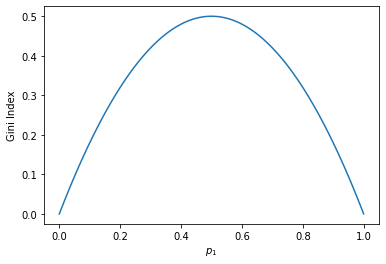

In [5]:
X = np.linspace(0, 1, 1001)
y = 1 - X*X - (1-X)*(1-X)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlabel("$p_1$")
ax.set_ylabel("Gini Index")
ax.plot(X, y)
plt.show()

A second impurity measure is the entropy measure. The entropy for a rectangle *A* is defined by:

<p style="text-align:center">
    $\text{entropy}(A) = - \sum \limits _{k=1}^{m} p_{k} \log_{2}(p_{k})$,
</p>

(to compute $\log_2 (x)$ in Python, use function `math.log2(x)`). This measure ranges between 0 (most pure, all records belong to the same class) and $\log_2 (m)$ (when all *m* classes are represented equally). In the two-class case, the entropy measure is maximized (like the Gini index) at $p_k$ = 0.5.

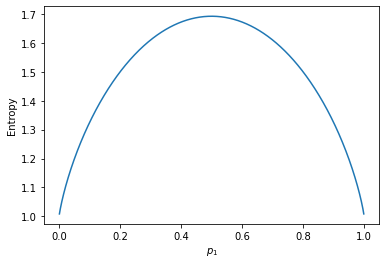

In [6]:
X = np.linspace(0.001, 0.999, 1001)
y = 1 - X*np.log(X) - (1-X)*np.log((1-X))

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlabel("$p_1$")
ax.set_ylabel("Entropy")
ax.plot(X, y)
plt.show()

Let us compute the impurity in the riding mower example before and after the first split (using Income with the value of 59.7). The unsplit dataset contains 12 owners and 12 nonowners. This is a two-class case with an equal number of records from each class. Both impurity measures are therefore at their maximum value: Gini = 0.5 and entropy = $\log_2 (2)$ = 1. After the split, the left rectangle contains seven nonowners and one owner. The impurity measures for this rectangle are:

<p style="text-align:center">
    $\text{gini_left} = 1 - (\frac {7}{8})^2 - (\frac {1}{8})^2 = 0.219$ <br />
    $\text{entropy_left} = - (\frac {7}{8}) \times \log_{2} (\frac{7}{8}) - (\frac {1}{8}) \times \log_{2} (\frac{1}{8}) = 0.544$
</p>

The right node contains 11 owners and 5 nonowners. The impurity measures of the right node are therefore:

<p style="text-align:center">
    $\text{gini_right} = 1 - (\frac {5}{16})^2 - (\frac {11}{16})^2 = 0.430$ <br />
    $\text{entropy_right} = - (\frac {5}{16}) \times \log_{2} (\frac{5}{16}) - (\frac {11}{16}) \times \log_{2} (\frac{11}{16}) = 0.896$
</p>

The combined impurity of the two nodes created by the split is a weighted average of the two impurity measures, weighted by the number of records in each:

<p style="text-align:center">
    $\text{gini} = (\frac {8}{24}) \times (0.219) + \frac {16}{24} \times (0.430) = 0.359$ <br />
    $\text{entropy} = (\frac {8}{24}) \times (0.544) + (\frac {16}{24}) \times (0.896) = 0.779$
</p>

Thus, the Gini impurity index decreased from 0.5 before the split to 0.359 after the split. Similarly, the entropy impurity measure decreased from 1 before the split to 0.779 after the split.

By comparing the reduction in impurity across all possible splits in all possible predictors, the next split is chosen. If we continue splitting the mower data, the next split is on the Lot Size variable at the value 21.4. The following figure shows that once again the tree procedure has astutely chosen to split a rectangle to increase the purity of the resulting rectangles. The lower-left rectangle, which contains records with Income ≤ 59.7 and Lot Size ≤ 21.4, has all records that are nonowners; whereas the upper-left rectangle, which contains records with Income ≤ 59.7 and Lot Size > 21.4, consists exclusively of a single owner. In other words, the two left rectangles are now "pure".

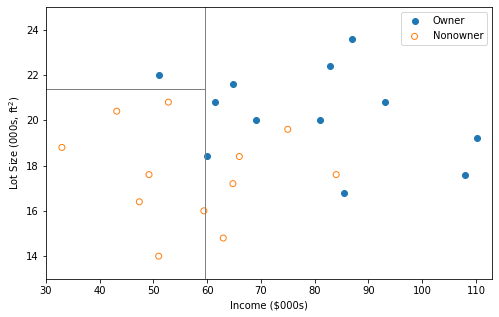

In [7]:
# plot first the data points for Ownership equals "Owner" and then of "Nonowner"
# setting color to "none" gives open circles

_, ax = plt.subplots(figsize=(8, 5))
for cat_value, color in [("Owner", "C0"), ("Nonowner", "C1")]:
    subset_df = mower_df[mower_df.Ownership == cat_value]
    if color == "C1":
        _color = "none"
    else:
        _color = color
    ax.scatter(subset_df.Income, subset_df.Lot_Size, color=_color,
               edgecolor=color, marker="o", label=cat_value)

ax.plot([59.7, 59.7], [13, 25], linewidth=1, color="gray")
ax.plot([30, 59.7], [21.4, 21.4], linewidth=1, color="gray")

ax.legend()
ax.set_xlabel("Income ($000s)")
ax.set_ylabel("Lot Size (000s, ft$^2$)")
ax.set_ylim([13, 25])
ax.set_xlim([30, 113])
plt.show()

We can see how the recursive partitioning is refining the set of constituent rectangles to become purer as the algorithm proceeds. The final stage of the recursive partitioning is shown next:

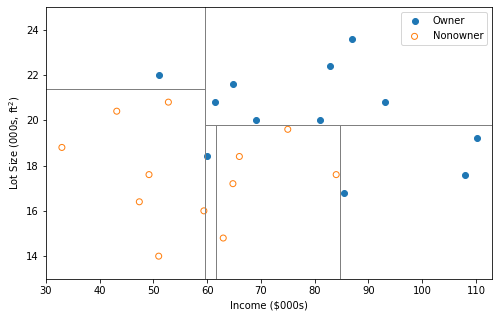

In [8]:
# plot first the data points for Ownership equals "Owner" and then of "Nonowner"
# setting color to "none" gives open circles

_, ax = plt.subplots(figsize=(8, 5))
for cat_value, color in [("Owner", "C0"), ("Nonowner", "C1")]:
    subset_df = mower_df[mower_df.Ownership == cat_value]
    if color == "C1":
        _color = "none"
    else:
        _color = color
    ax.scatter(subset_df.Income, subset_df.Lot_Size, color=_color,
               edgecolor=color, marker="o", label=cat_value)

ax.plot([59.7, 59.7], [13, 25], linewidth=1, color="gray")
ax.plot([30, 59.7], [21.4, 21.4], linewidth=1, color="gray")
ax.plot([61.6, 61.6], [13, 19.8], linewidth=1, color="gray")
ax.plot([84.75, 84.75], [13, 19.8], linewidth=1, color="gray")
ax.plot([59.7, 113], [19.8, 19.8], linewidth=1, color="gray")

ax.legend()
ax.set_xlabel("Income ($000s)")
ax.set_ylabel("Lot Size (000s, ft$^2$)")
ax.set_ylim([13, 25])
ax.set_xlim([30, 113])
plt.show()

Notice that each rectangle is now pure: it contains data points from just one of the two classes.

The reason the method is called a classification tree algorithm is that each split can be depicted as a split of a node into two successor nodes. The first split is shown as a branching of the root node of a tree in the first figure above. The tree showing the first three splits is shown in the second figure above. The full-grown tree is shown lastly.

Classes: Nonowner, Owner


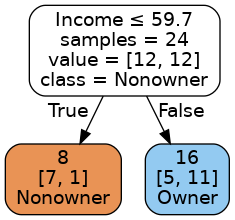

In [9]:
mower_df = pd.read_csv("../datasets/RidingMowers.csv")

# use max_depth to control tree size (None = full tree)
class_tree = DecisionTreeClassifier(random_state=0, max_depth=1)
class_tree.fit(mower_df.drop(columns=["Ownership"]), mower_df["Ownership"])

print("Classes: {}".format(", ".join(class_tree.classes_)))
plot_decision_tree(class_tree, feature_names=mower_df.columns[:2],
                   class_names=class_tree.classes_)

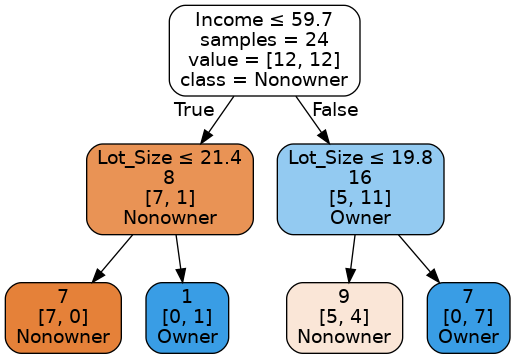

In [10]:
# use max_depth to control tree size (None = full tree)
class_tree = DecisionTreeClassifier(random_state=0, max_depth=2)
class_tree.fit(mower_df.drop(columns=["Ownership"]), mower_df["Ownership"])

plot_decision_tree(class_tree, feature_names=mower_df.columns[:2],
                   class_names=class_tree.classes_)

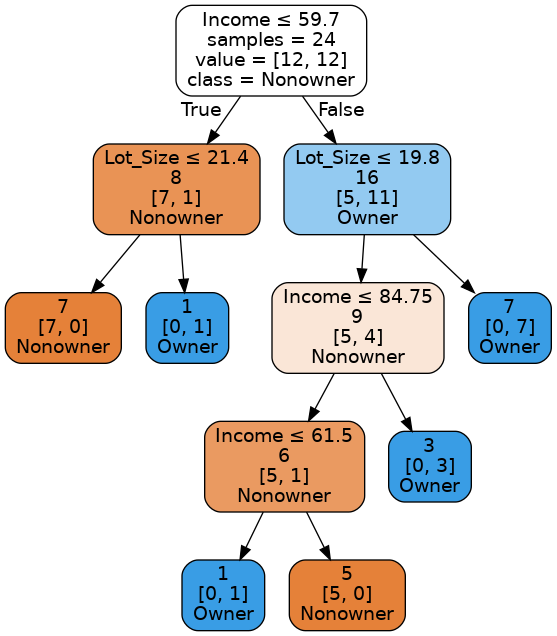

In [11]:
# use max_depth to control tree size (None = full tree)
class_tree = DecisionTreeClassifier(random_state=0, max_depth=None)
class_tree.fit(mower_df.drop(columns=["Ownership"]), mower_df["Ownership"])

plot_decision_tree(class_tree, feature_names=mower_df.columns[:2],
                   class_names=class_tree.classes_)

## Evaluating the Performance of a Classification Tree

We have seen with previous methods that the modeling job is not completed by fitting a model to training data; we need out-of-sample data to assess and tune the model. This is particularly true with classification and regression trees, for two reasons:

- Tree structure can be quite unstable, shifting substantially depending on the sample chosen.
- A fully-fit tree will invariably lead to overfitting.

To visualize the first challenge, potential instability, imagine that we partition the data randomly into two samples, A and B, and we build a tree with each. If there are several predictors of roughly equal predictive power, you can see that it would be easy for samples A and B to select different predictors for the top level split, just based on which records ended up in which sample. And a different split at the top level would likely cascade down and yield completely different sets of rules. So we should view the results of a single tree with some caution.

To illustrate the second challenge, overfitting, let's examine another example.

### Example 2: Acceptance of Personal Loan

Universal Bank is a relatively young bank that is growing rapidly in terms of overall customer acquisition. The majority of these customers are liability customers with varying sizes of relationship with the bank. The customer base of asset customers is quite small, and the bank is interested in growing this base rapidly to bring in more loan business. In particular, it wants to explore ways of converting its liability (deposit) customers to personal loan customers.

A campaign the bank ran for liability customers showed a healthy conversion rate of over 9% successes. This has encouraged the retail marketing department to devise smarter campaigns with better target marketing. The goal of our analysis is to model the previous campaign's customer behavior to analyze what combination of factors make a customer more likely to accept a personal loan. This will serve as the basis for the design of a new campaign.

Our predictive model will be a classification tree. To assess the accuracy of the tree in classifying new
records, we start with the tools and criteria discussed in [Evaluating Prediction Performance](evaluating-predictive-performance.ipynb) - partitioning the data into training and validation sets, and later introduce the idea of *cross-validation*.

The bank's dataset includes data on 5000 customers. The data include customer demographic information (age, income, etc.), customer response to the last personal loan campaign (Personal Loan), and the customer's relationship with the bank (mortgage, securities account, etc.). The following table shows a sample of the bank's customer database for 20 customers, to illustrate the structure of the data. Among these 5000 customers, only 480 (=9.6%) accepted the personal loan that was offered to them in the earlier campaign.

In [12]:
bank_df = pd.read_csv("../datasets/UniversalBank.csv")
bank_df.head(20)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
5,6,37,13,29,92121,4,0.4,2,155,0,0,0,1,0
6,7,53,27,72,91711,2,1.5,2,0,0,0,0,1,0
7,8,50,24,22,93943,1,0.3,3,0,0,0,0,0,1
8,9,35,10,81,90089,3,0.6,2,104,0,0,0,1,0
9,10,34,9,180,93023,1,8.9,3,0,1,0,0,0,0


After randomly partitioning the data into training (3000 records) and validation (2000 records), we use the training data to construct a tree. The result is shown below - this is the default tree produced by `DecisionTreeClassifier()` for these data. Although it is difficult to see the exact splits, we note that the top decision node refers to all the records in the training set, of which 2704 customers did not accept the loan and 296 customers accepted the loan. The "class = 0" in the top node represents the majority class (nonacceptors). The first split, which is on the Income variable, generates left and right child nodes. To the left is the child node with customers who have income of 106.5 or lower. Customers with income greater than 106.5 go to the right. The splitting process continues; where it stops depends on the parameter settings of the algorithm. The eventual classification of customer appears in the terminal nodes. Of the 43 terminal nodes, 24 lead to classification of "nonacceptor" and 19 lead to classification of "acceptor".

The default tree has no restrictions on the maximum depth of the tree (or number of leaf nodes), nor on the magnitude of decrease in impurity measure. These default values for the parameters controlling the size of the tree lead to a fully grown tree, with pure leaf nodes. The full grown tree is shown below.

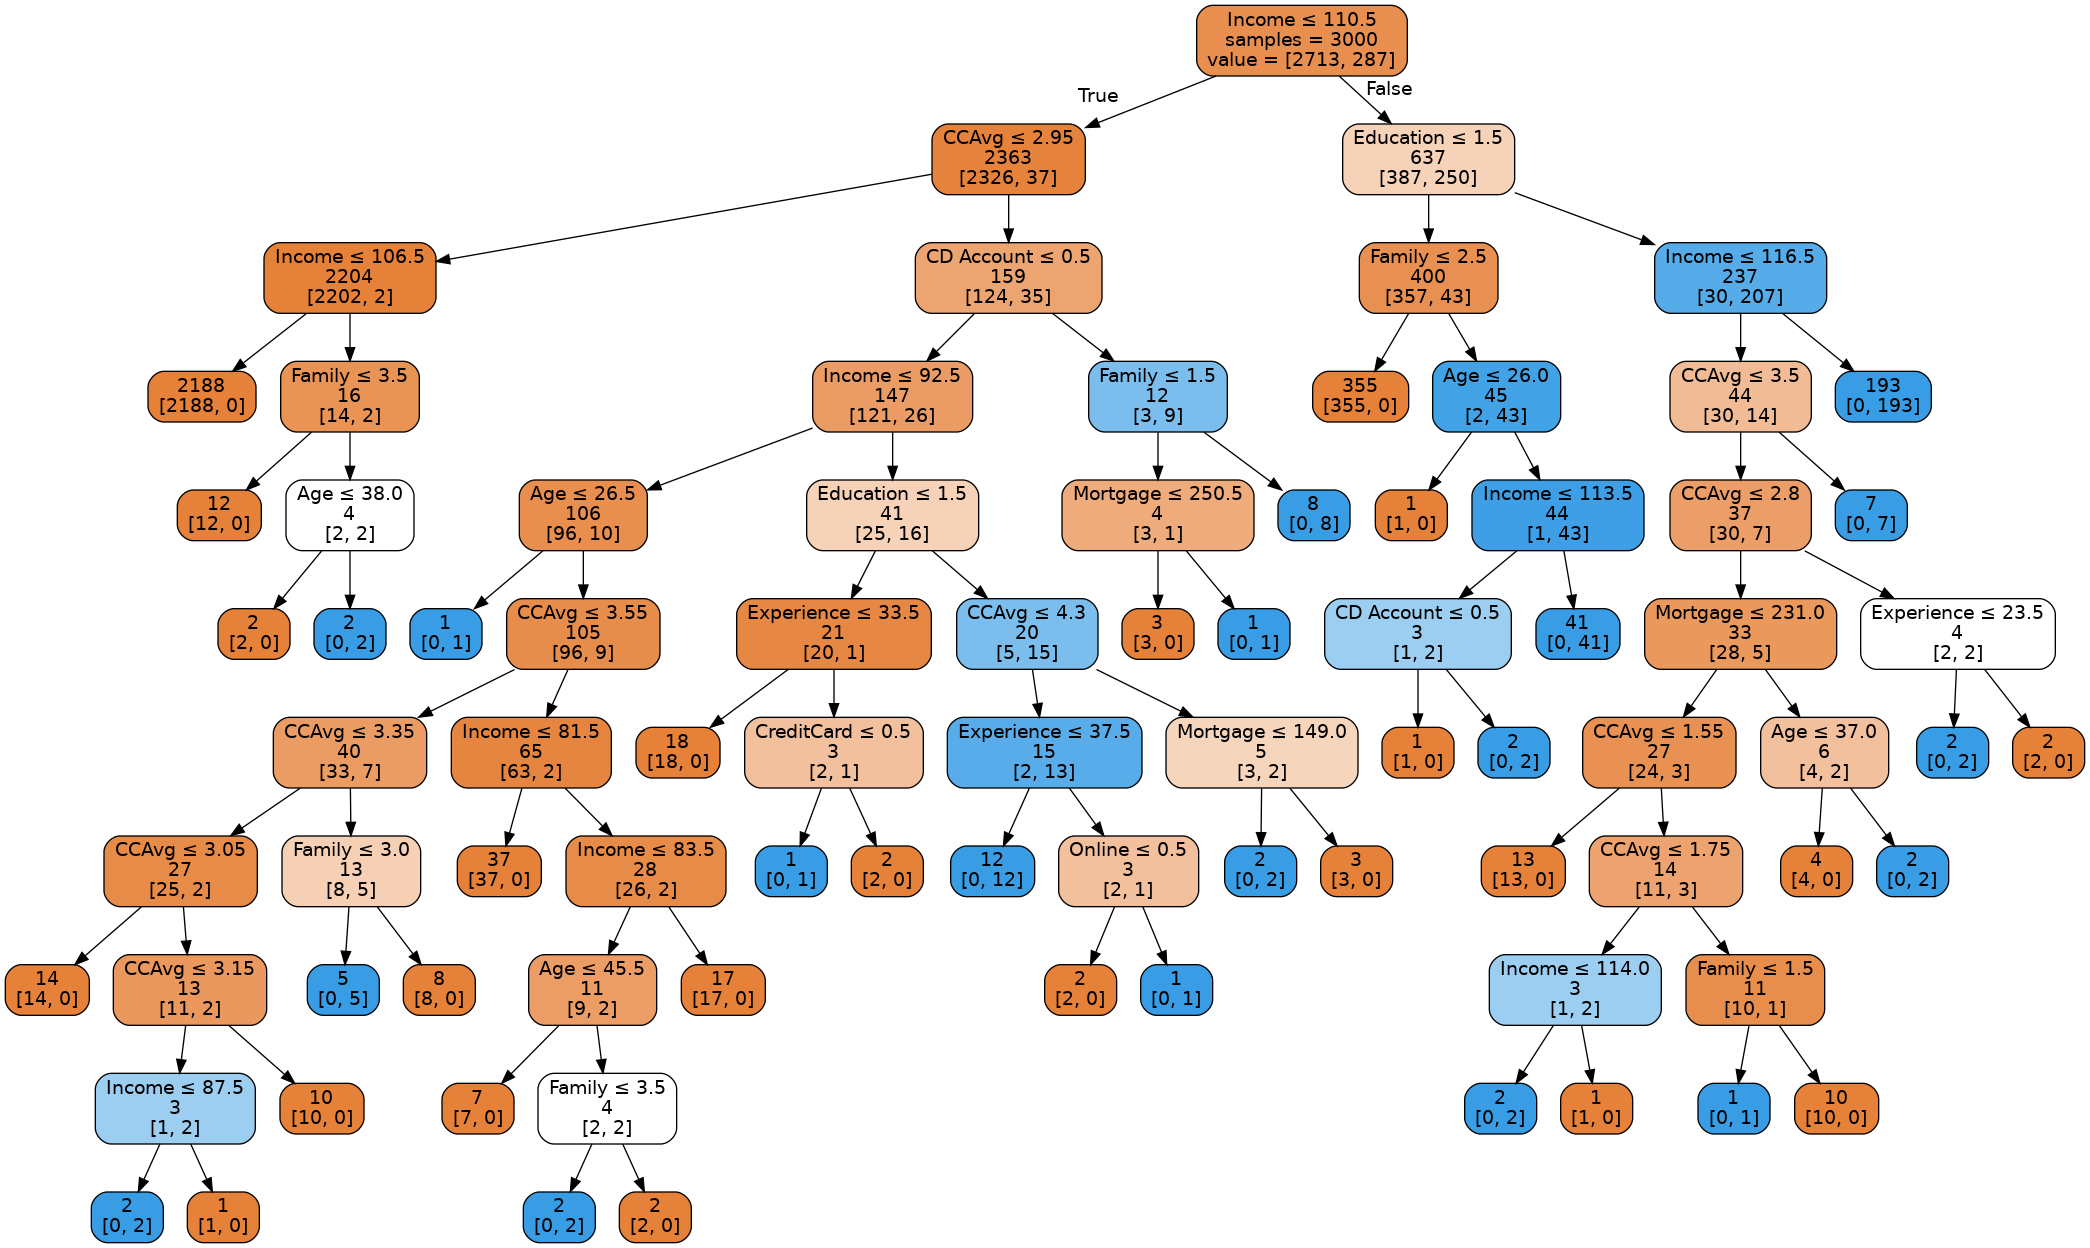

In [13]:
bank_df.drop(columns=["ID", "ZIP Code"], inplace=True)

X = bank_df.drop(columns=["Personal Loan"])
y = bank_df["Personal Loan"]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

full_class_tree = DecisionTreeClassifier(random_state=1)
full_class_tree.fit(train_X, train_y)

plot_decision_tree(full_class_tree, feature_names=train_X.columns)

Let us assess the performance of this full tree with the validation data. Each record in the validation data is "dropped down" the tree and classified according to the terminal node it reaches. These predicted classes can then be compared to the actual outcome via a confusion matrix. When a particular class is of interest, a lift chart is useful for assessing the model's ability to capture those records.

In [14]:
classification_summary(train_y, full_class_tree.predict(train_X))
print()
classification_summary(valid_y, full_class_tree.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 2713    0
     1    0  287

Confusion Matrix (Accuracy 0.9790)

       Prediction
Actual    0    1
     0 1790   17
     1   25  168


The above table shows the confusion matrices for the full grown tree. We see that the training data are perfectly classified (accuracy = 1), whereas the validation data have a lower accuracy (0.98).

### Sensitivity Analysis Using Cross Validation

Due to the issue of tree instability, it is possible that the performance results will differ markedly when using a different partitioning into training and validation data. It is therefore useful to use cross-validation to evaluate the variability in performance on different data partitioning. The following table shows code and the result of applying Python's `cross_val_score` method to perform 5-fold cross-validation on the full grown (default) tree. We see that the validation accuracy changes significantly across different folds from 0.972 to 0.992.

In [15]:
class_tree = DecisionTreeClassifier(random_state=1)
scores = cross_val_score(class_tree, train_X, train_y, cv=5)

print("Accuracy scores of each fold: ", [f"{acc:.3f}" for acc in scores])

Accuracy scores of each fold:  ['0.988', '0.973', '0.993', '0.982', '0.993']


## Avoiding Overfitting

One danger in growing deep trees on the training data is overfitting. As discussed in [Evaluating Prediction Performance](evaluating-predictive-performance.ipynb), overfitting will lead to poor performance on new data. If we look at the overall error at the various sizes of the tree, it is expected to decrease as the number of terminal nodes grows until the point of overfitting. Of course, for the training data the overall error decreases more and more until it is zero at the maximum level of the tree. However, for new data, the overall error is expected to decrease until the point where the tree fully models the relationship between class and the predictors. After that, the tree starts to model the noise in the training set, and we expect the overall error for the validation set to start increasing. This is depicted in figure below. One intuitive reason a large tree may overfit is that its final
splits are based on very small numbers of records. In such cases, class difference is likely to be attributed
to noise rather than predictor information.

![alt text](../images/error-rate-as-a-function-of-the-number-of-splits-for-training-vs-validation-data-overfitting.png)

### Stopping Tree Growth

One can think of different criteria for stopping the tree growth before it starts overfitting the data. Examples are tree depth (i.e., number of splits), minimum number of records in a terminal node, and minimum reduction in impurity. In Python's `DecisionTreeClassifier()`, we can control the depth of the tree, the minimum number of records in a node needed in order to split, the mimimum number of records in a terminal node, etc. The problem is that it is not simple to determine what is a good stopping point using such rules.

Let us return to the personal loan example, this time restricting tree depth, the minimum number of records in a node required for splitting, and the minimum impurity decrease required. The code and resulting tree are shown below. The resulting tree has four terminal nodes, where two are pure but two are not. The smallest terminal node has 44 records.

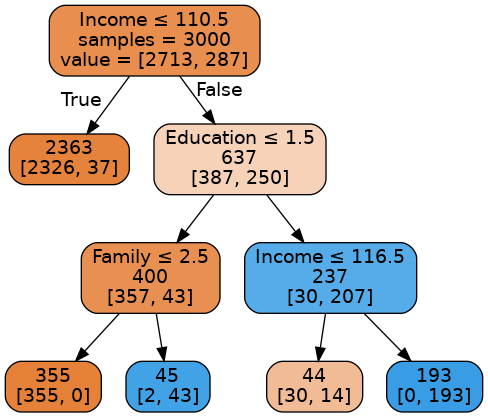

In [16]:
small_class_tree = DecisionTreeClassifier(max_depth=30, min_samples_split=20,
                                          min_impurity_decrease=0.01, random_state=1)
small_class_tree.fit(train_X, train_y)

plot_decision_tree(small_class_tree, feature_names=train_X.columns)

The following table displays the confusion matrices for the training and validation sets of the smaller tree.
Compared to the full grown tree, we see that the full tree has higher training accuracy: it is 100% accurate in classifying the training data, which means it has completely pure terminal nodes. The smaller tree achieves the same validation performance, but importantly, it has a smaller gap in performance between training and validation, whereas the full tree's training-vs.-validation performance gap is bigger. The main reason is that the full-grown tree overfits the training data (to perfect accuracy!).

In [17]:
classification_summary(train_y, small_class_tree.predict(train_X))
print()
classification_summary(valid_y, small_class_tree.predict(valid_X))

Confusion Matrix (Accuracy 0.9823)

       Prediction
Actual    0    1
     0 2711    2
     1   51  236

Confusion Matrix (Accuracy 0.9770)

       Prediction
Actual    0    1
     0 1804    3
     1   43  150


### Fine-tuning Tree Parameters

As mentioned earlier, the challenge with using tree growth stopping rules such as maximum tree depth is that it is not simple to determine what is a good stopping point using such rules. A solution is to use grid search over combinations of different parameter values. For example, we might want to search for trees with {maximum depths in the range of [5, 30], minimum number of records in terminal nodes between [20, 100], impurity criterion decrease in the range [0.001, 0.01]}. We can use an exhaustive grid search to find the combination that leads to the tree with smallest error (highest accuracy).

If we use the training set to find the tree with the lowest error among all the trees in the searched range, measuring accuracy on that same training data, then we will be overfitting the training data. If we use the validation set to measure accuracy, then, with the numerous grid search trials, we will be overfitting the validation data! A solution is therefore to use cross-validation on the training set, and, after settling on the best tree, use that tree with the validation data to evaluate likely actual performance with new data. This will help detect and avoid possible overfitting.

In Python, an exhaustive grid search of this type can be achieved using `GridSearchCV()`.The following code shows result of using this method with 5-fold cross-validation. The resulting parameter combination is max_depth 5, min_impurity_decrease 0.0011, and min_samples_split 13. The final tree and the model performance on the training and validation sets are shown below.

In [18]:
# Start with an initial guess for parameters
param_grid = {
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [20, 40, 60, 80, 100],
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01]
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5,
                           n_jobs=-1) # n_jobs = -1 will utilize all available CPUs
grid_search.fit(train_X, train_y)
print('Initial score: ', grid_search.best_score_)
print('Initial parameters: ', grid_search.best_params_)

# Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(2, 16)), # 14 values,
    'min_samples_split': list(range(10, 22)), # 11 values,
    'min_impurity_decrease': [0.0009, 0.001, 0.00111], # 3 values
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5,
                           n_jobs=-1)
grid_search.fit(train_X, train_y)
print('Improved score: ', grid_search.best_score_)
print('Improved parameters: ', grid_search.best_params_)

best_class_tree = grid_search.best_estimator_

Initial score:  0.9876666666666667
Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0.0005, 'min_samples_split': 20}
Improved score:  0.9873333333333333
Improved parameters:  {'max_depth': 4, 'min_impurity_decrease': 0.00111, 'min_samples_split': 13}


In [19]:
# fine-tuned tree: training
classification_summary(train_y, best_class_tree.predict(train_X))

Confusion Matrix (Accuracy 0.9867)

       Prediction
Actual    0    1
     0 2708    5
     1   35  252


In [20]:
# fine-tuned tree: validation
classification_summary(valid_y, best_class_tree.predict(valid_X))

Confusion Matrix (Accuracy 0.9815)

       Prediction
Actual    0    1
     0 1801    6
     1   31  162


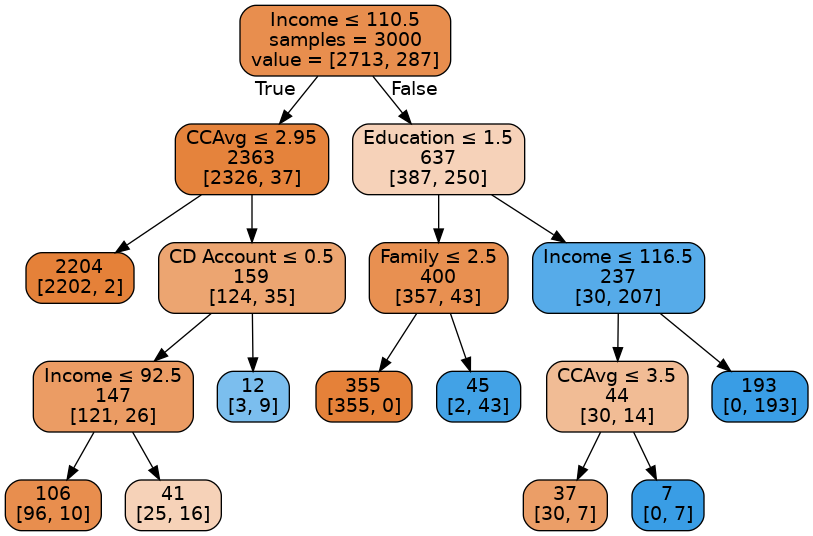

In [21]:
plot_decision_tree(best_class_tree, feature_names=train_X.columns)

The exhaustive grid search can quickly become very time consuming. In our example, the first grid search assessed 4 x 5 x 5 = 100 combinations and the second 14 x 11 x 3 = 462 combinations. With even more tune-able parameters the number of possible combinations can become very large. In this case it is better to use `RandomizedSearchCV()` which will randomly sample all possible combinations while limiting the total number of tries (parameter `n_iter`). With `RandomizedSearchCV()`, it is also possible to sample parameter from distributions (e.g., any number between 0 and 1) without listing them individually.

### Other Methods for Limiting Tree Size

Several other methods for limiting tree size have been used widely. They are not implemented in Python at this writing, but we note them here for completeness.

- **CHAID**

CHAID stands for chi-squared automatic interaction detection, a recursive partitioning method that predates classification and regression tree (CART) procedures by several years and is widely used in database marketing applications to this day. It uses a well-known statistical test (the chi-square test for independence) to assess whether splitting a node improves the purity by a statistically significant amount. In particular, at each node, we split on the predictor with the strongest association with the outcome variable. The strength of association is measured by the p-value of a chi-squared test of independence. If for the best predictor the test does not show a significant improvement, the split is not carried out, and the tree is terminated. A more general class of trees based on this idea is called *conditional inference trees* (see Hothorn et al., 2006).

- **Pruning**

The idea behind pruning is to recognize that a very large tree is likely to overfit the training data, and that the smallest branches, which are the last to be grown and are furthest from the trunk, are likely fitting noise in the training data. They may actually contribute to error in fitting new data, so they are lopped off. Pruning the full-grown tree is the basis of the popular CART method (developed by Breiman et al., implemented in multiple data mining software packages such as R’s rpart package, SAS Enterprise Miner, CART, and MARS) and C4.5 (developed by Quinlan and implemented in packages such as IBM SPSS Modeler). In C4.5, the training data are used both for growing and pruning the tree. In CART, the innovation is to use the validation data to prune back the tree that is grown from training data.

More specifically, the CART algorithm uses a cost-complexity function that balances tree size (complexity) and misclassification error (cost) in order to choose tree size. The cost complexity of a tree is equal to its misclassification error (based on the training data) plus a penalty factor for the size of the tree. For a tree $T$ that has $L(T)$ terminal nodes, the cost complexity can be written as

<p style="text-align:center">
    $CC(T) = \text{err}(T) + \alpha L(T)$
</p>

where $\text{err}(T)$ is the fraction of training records that are misclassified by tree $T$ and $\alpha$ is a penalty factor ("complexity parameter") for tree size. When $\alpha$ = 0, there is no penalty for having too many nodes in a tree, and this yields the full-grown unpruned tree. When we increase $\alpha$ to a very large value the penalty cost component swamps the misclassification error component of the cost complexity criterion, and the result is simply the tree with the fewest terminal nodes: namely, the tree with one node. So there is a range of trees, from tiny to large, corresponding to a range of $\alpha$, from large to small. From this sequence of trees it seems natural to choose the one that gave the lowest misclassification error on the validation dataset. Alternatively, rather than relying on a single validation partition, we can use *k-fold cross-validation* for choosing $\alpha$.

## Classification Rules from Trees

As described earlier, classification trees provide easily understandable *classification rules* (if the trees are not too large). Each terminal node is equivalent to a classification rule. Returning to the above example, the left-most terminal node in the fine-tuned tree gives us the rule

    IF (Income ≤ 110.5) AND (CCAvg ≤ 2.95) THEN Class = 0

However, in many cases, the number of rules can be reduced by removing redundancies. For example, consider the rule from the second-from-bottom-left-most terminal node in the figure:

    IF (Income ≤ 110.5) AND (CCAvg > 2.95) AND (CD.Account ≤ 0.5) AND (Income ≤ 92.5) THEN Class = 0

This rule can be simplified to

    IF (Income ≤ 92.5) AND (CCAvg > 2.95) AND (CD.Account ≤ 0.5) THEN Class = 0

This transparency in the process and understandability of the algorithm that leads to classifying a record as belonging to a certain class is very advantageous in settings where the final classification is not the only thing of interest. Berry and Linoff (2000) give the example of health insurance underwriting, where the insurer is required to show that coverage denial is not based on discrimination. By showing rules that led to denial (e.g., income < \\$20K AND low credit history), the company can avoid law suits. Compared to the output of other classifiers, such as discriminant functions, tree-based classification rules are easily explained to managers and operating staff. Their logic is certainly far more transparent than that of weights in neural networks!

## Classification Trees for More Than Two Classes

Classification trees can be used with an outcome variable that has more than two classes. In terms of measuring impurity, the two measures presented earlier (the Gini impurity index and the entropy measure) were defined for *m* classes and hence can be used for any number of classes. The tree itself would have the same structure, except that its terminal nodes would take one of the *m*-class labels.

## Regression Trees

The tree method can also be used for a numerical outcome variable. Regression trees for prediction operate in much the same fashion as classification trees. The outcome variable ($Y$) is a numerical variable in this case, but both the principle and the procedure are the same: Many splits are attempted,and for each, we measure "impurity" in each branch of the resulting tree. The tree procedure then selects the split that minimizes the sum of such measures.

To illustrate a regression tree, consider the example of predicting prices of Toyota Corolla automobiles (from [Multiple Linear Regression](multiple-linear-regression.ipyb). The dataset includes information on 1000 sold Toyota Corolla cars. (We use the first 1000 cars from the dataset `ToyotoCorolla.csv`). The goal is to find a predictive model of price as a function of 10 predictors (including mileage, horsepower, number of doors, etc.). A regression tree for these data was built using a training set of 600 records. The fine-tuned tree is shown below.

In [22]:
toyota_corolla_df = pd.read_csv("../datasets/ToyotaCorolla.csv").iloc[:1000, :]
toyota_corolla_df = toyota_corolla_df.rename(columns={'Age_08_04': 'Age', 'Quarterly_Tax': 'Tax'})

predictors = ['Age', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'CC', 'Doors', 'Tax', 'Weight']
outcome = 'Price'

X = pd.get_dummies(toyota_corolla_df[predictors], drop_first=True)
y = toyota_corolla_df[outcome]

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# user grid search to find optimized tree
param_grid = {
    'max_depth': [5, 10, 15, 20, 25],
    'min_impurity_decrease': [0, 0.001, 0.005, 0.01],
    'min_samples_split': [10, 20, 30, 40, 50]
}

grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
grid_search.fit(train_X, train_y)
print('Initial parameters: ', grid_search.best_params_)

param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'min_impurity_decrease': [0, 0.001, 0.002, 0.003, 0.005, 0.006, 0.007, 0.008],
    'min_samples_split': [14, 15, 16, 18, 20]
}

grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
grid_search.fit(train_X, train_y)

reg_tree = grid_search.best_estimator_

regression_summary(train_y, reg_tree.predict(train_X))
print()
regression_summary(valid_y, reg_tree.predict(valid_X))

Initial parameters:  {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 20}

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1058.8202
            Mean Absolute Error (MAE) : 767.7203
          Mean Percentage Error (MPE) : -0.8074
Mean Absolute Percentage Error (MAPE) : 6.8325


Regression statistics

                      Mean Error (ME) : 60.5241
       Root Mean Squared Error (RMSE) : 1554.9146
            Mean Absolute Error (MAE) : 1026.3487
          Mean Percentage Error (MPE) : -1.3082
Mean Absolute Percentage Error (MAPE) : 9.2311


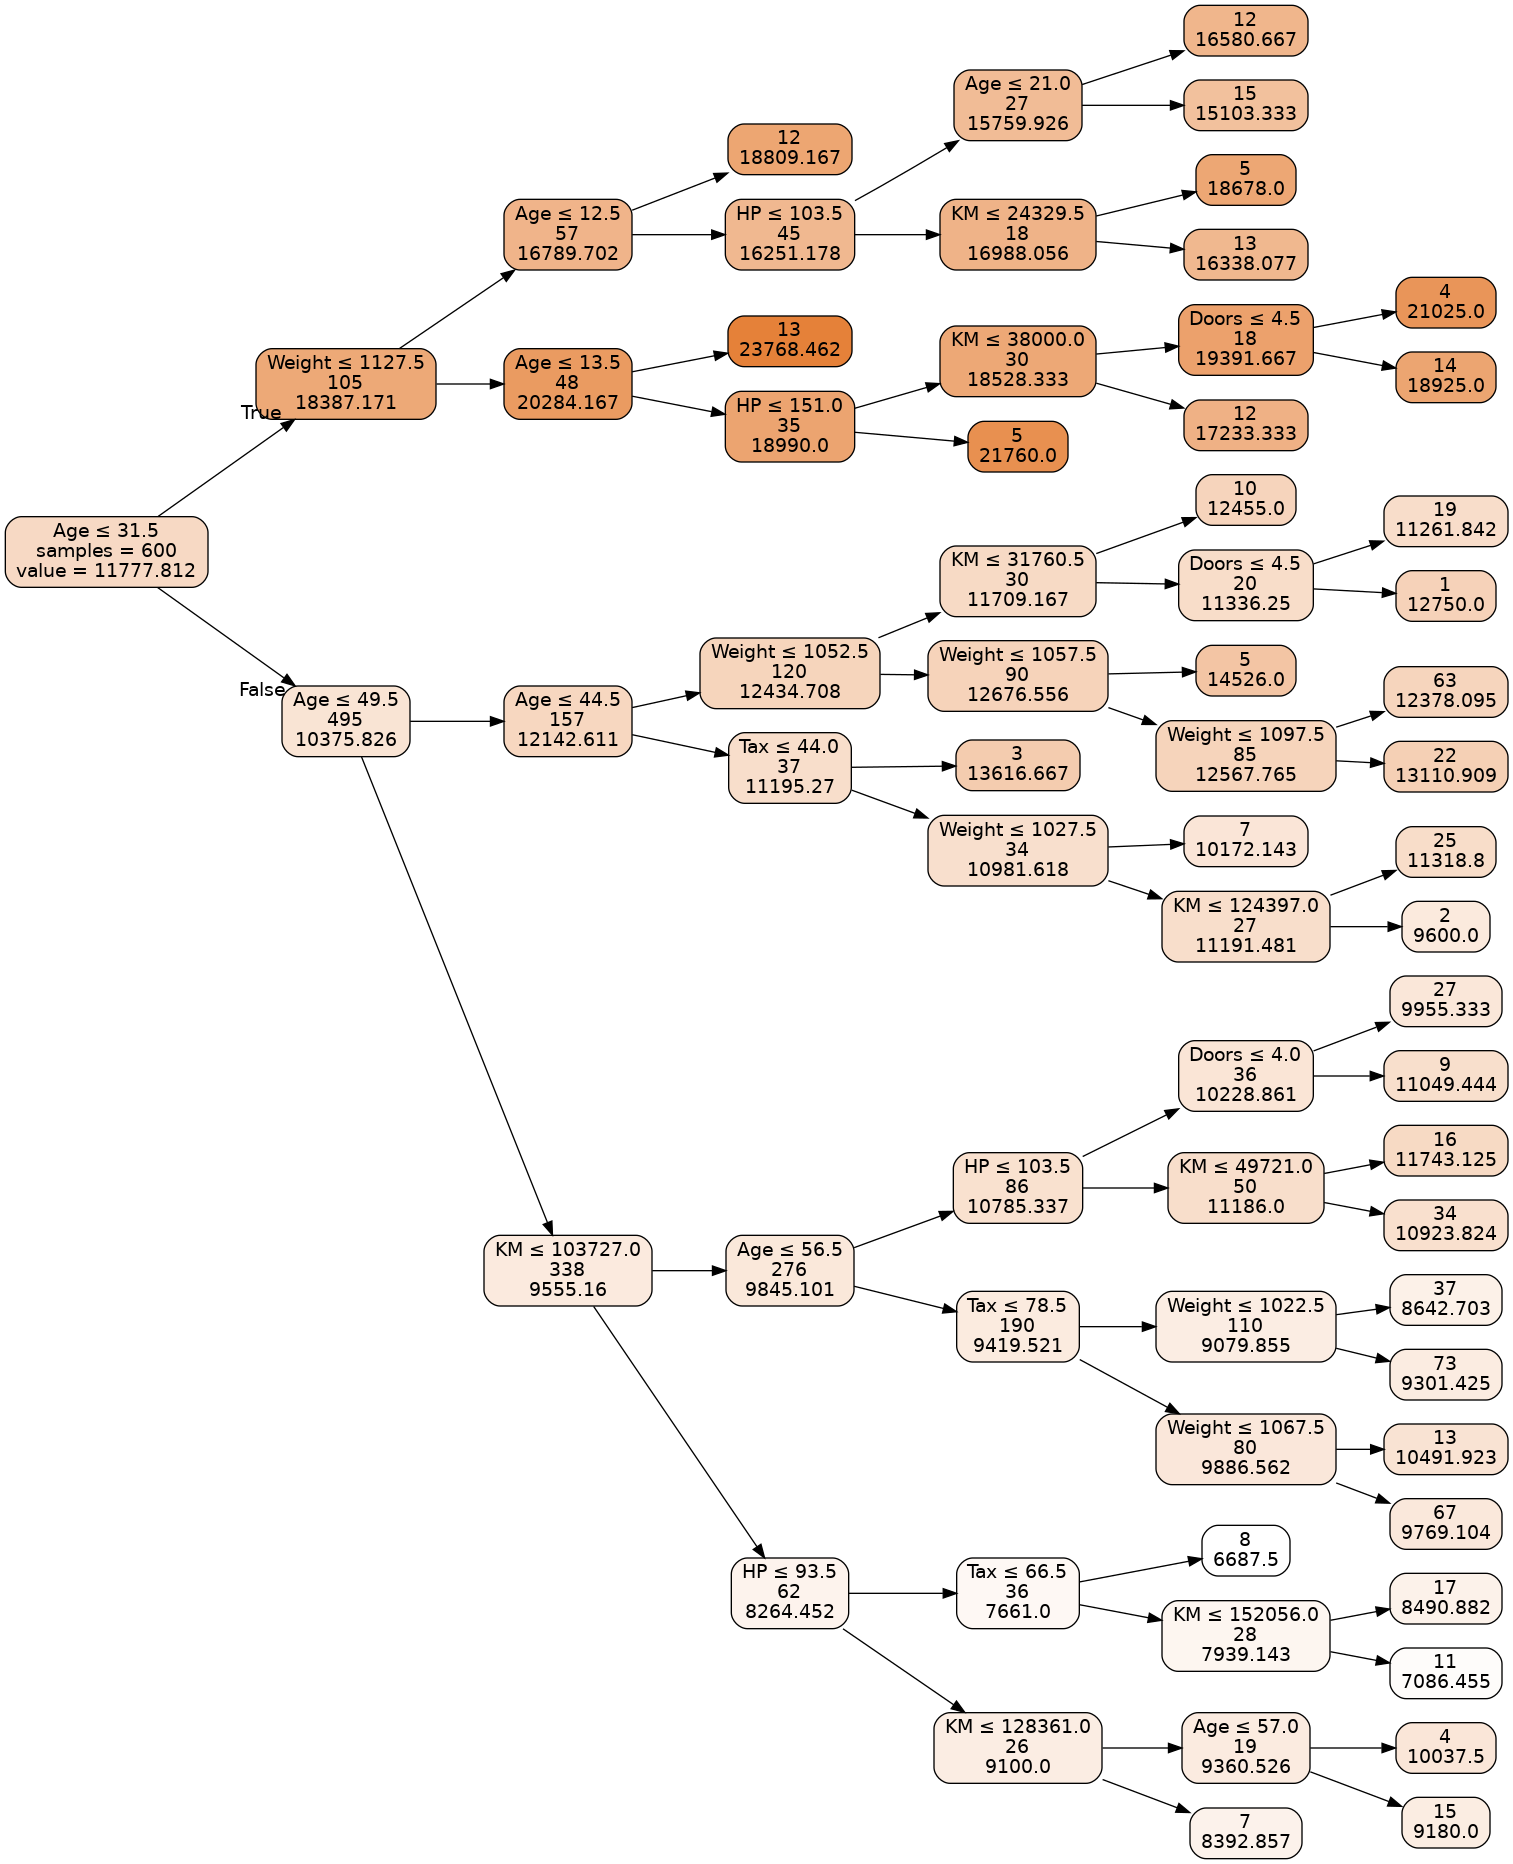

In [23]:
plot_decision_tree(reg_tree, feature_names=train_X.columns, rotate=True)

We see that the top three levels of the regression tree are dominated by age of the car, its weight, and mileage. In the lower levels we can see that individual details of a car, like powered windows, lead to smaller adjustments of the price.

Three details differ between regression trees and classification trees: prediction, impurity measures, and evaluating performance. We describe these next.

### Prediction

Predicting the outcome value for a record is performed in a fashion similar to the classification case: We will use the truncated tree from above to demonstrate how it works. The predictor information is used for "dropping" the record down the tree until reaching a terminal node. For instance, to predict the price of a Toyota Corolla with
    
    Age = 60,
    Mileage (KM) = 160,000, and
    Horse_Power (HP) = 100,

we drop it down the tree and reach the node that has the value \\$8392.857 (the lowest node).This is the price prediction for this car according to the tree. In classification trees, the value of the terminal node (which is one of the categories) is determined by the "voting" of the training records that were in that terminal node. In regression trees, the value of the terminal node is determined by the average outcome value of the training records that were in that terminal node. In the example above, the value \\$8392.857 is the average price of the 7 cars in the training set that fall in the category of
    
    Age > 49.5,
    KM > 128361,
    and HP > 93.5.

### Measuring Impurity

We described two types of impurity measures for nodes in classification trees: the Gini index and the entropy-based measure. In both cases, the index is a function of the *ratio* between the categories of the records in that node. In regression trees, a typical impurity measure is the sum of the squared deviations from the mean of the terminal node. This is equivalent to the sum of the squared errors, because the mean of the terminal node is exactly the prediction. In the example above, the impurity of the node with the value \\$8392.857 is computed by subtracting 8392.857 from the price of each of the 7 cars in the training set that fell in that terminal node, then squaring these deviations and summing them up. The lowest impurity possible is zero, when all values in the node are equal.

### Evaluating Performance

As stated above, predictions are obtained by averaging the outcome values in the nodes. We therefore have the usual definition of predictions and errors. The predictive performance of regression trees can be measured in the same way that other predictive methods are evaluated (e.g., linear regression), using summary measures such as RMSE. 

## Improving Prediction: Random Forests and Boosted Trees

Notwithstanding the transparency advantages of a single tree as described above, in a pure prediction application, where visualizing a set of rules does not matter, better performance is provided by several extensions to trees that combine results from multiple trees. These are examples of *ensembles*. One popular multitree approach is *random forests*, introduced by Breiman and Cutler. Random forests are a special case of *bagging*, a method for improving predictive power by combining multiple classifiers or prediction algorithms.

### Random Forests

The basic idea in random forests is to:

1. Draw multiple random samples, with replacement, from the data (this sampling approach is called the *bootstrap*).
2. Using a random subset of predictors at each stage, fit a classification (or regression) tree to each sample (and thus obtain a "forest")
3. Combine the predictions/classifications from the individual trees to obtain improved predictions. Use voting for classification and averaging for prediction.

The code and output in the table below illustrates applying a random forest in Python to the personal loan example. The validation accuracy of the random forest in this example (0.982) is similar to the single fine-tuned tree, and slightly higher than the single small tree that we fit earlier (0.977). 

Unlike a single tree, results from a random forest cannot be displayed in a tree-like diagram, thereby losing the interpretability that a single tree provides. However, random forests can produce "variable importance" scores, which measure the relative contribution of the different predictors. The importance score for a particular predictor is computed by summing up the decrease in the Gini index for that predictor over all the trees in the forest.

               feature  importance       std
7   Securities Account    0.003964  0.004998
9               Online    0.006394  0.005350
10          CreditCard    0.007678  0.007053
6             Mortgage    0.034243  0.023469
1           Experience    0.035539  0.016061
0                  Age    0.036258  0.015858
8           CD Account    0.057917  0.043185
3               Family    0.111375  0.053146
4                CCAvg    0.172105  0.103011
5            Education    0.200772  0.101002
2               Income    0.333756  0.129227


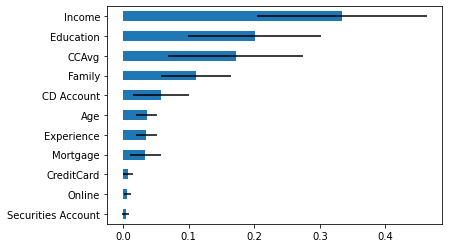

Confusion Matrix (Accuracy 0.9820)

       Prediction
Actual    0    1
     0 1803    4
     1   32  161


In [24]:
bank_df = pd.read_csv("../datasets/UniversalBank.csv")
bank_df.drop(columns=["ID", "ZIP Code"], inplace=True)

X = bank_df.drop(columns=["Personal Loan"])
y = bank_df["Personal Loan"]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y)

# variable (feature) importance plot
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')
print(df)

ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')
plt.show()

# confusion matrix for validation set
classification_summary(valid_y, rf.predict(valid_X))

The above figure shows the variable importance plot generated from the random forest model for the personal loan example. We see that Income and Education have the highest scores, with `CCAvg` being third. Importance scores for the other predictors are considerably lower.

### Boosted Trees

The second type of multitree improvement is *boosted trees*. Here a sequence of trees is fitted, so that each tree concentrates on misclassified records from the previous tree.

1. Fit a single tree.
2. Draw a sample that gives higher selection probabilities to misclassified records.
3. Fit a tree to the new sample.
4. Repeat Steps 2 and 3 multiple times.
5. Use weighted voting to classify records, with heavier weight for later trees.

The following table shows the result of running a boosted tree on the loan acceptance example that we saw earlier.
We can see that compared to the performance of the single small tree, the boosted tree has better performance on the validation data in terms of overall accuracy (0.9835) and especially in terms of correct classification of 1's - the rare class of special interest. Where does boosting's special talent for finding 1's come from? When one class is dominant (0's constitute over 90% of the data here), basic classifiers are tempted to classify cases as belonging to the dominant class, and the 1's in this case constitute most of the misclassifications with the single tree. The boosting algorithm concentrates on the misclassifications (which are mostly 1's), so it is naturally going to do well in reducing the misclassification of 1's (from 43 in the single small tree to 25 in the boosted tree, in the validation set).

In [25]:
boost = GradientBoostingClassifier()
boost.fit(train_X, train_y)

classification_summary(valid_y, boost.predict(valid_X))

Confusion Matrix (Accuracy 0.9835)

       Prediction
Actual    0    1
     0 1799    8
     1   25  168


## Advantages and Weaknesses of a Tree

Tree methods are good off-the-shelf classifiers and predictors. They are also useful for variable selection, 
with the most important predictors usually showing up at the top of the tree. Trees require relatively little effort from users in the following senses: First, there is no need for transformation of variables (any monotone transformation of the variables will give the same trees). Second, variable subset selection is automatic since it is part of the split selection. In the loan example, note that out of the set of 14 predictors available, the small tree automatically selected only three predictors (Income, Education, and Family) and the fine-tuned tree selected five (Income, Education, Family, CCAvg, and CD Account).

Trees are also intrinsically robust to outliers, since the choice of a split depends on the *ordering* of values and not on the absolute *magnitudes* of these values. However, they are sensitive to changes in the data, and even a slight change can cause very different splits!

Unlike models that assume a particular relationship between the outcome and predictors (e.g., a linear relationship such as in linear regression and linear discriminant analysis), classification and regression trees are nonlinear and nonparametric. This allows for a wide range of relationships between the predictors and the outcome variable. However, this can also be a weakness: Since the splits are done on one predictor at a time, rather than on combinations of predictors, the tree is likely to miss relationships between predictors, in particular linear structures like those in linear or logistic regression models.

Classification trees are useful classifiers in cases where horizontal and vertical splitting of the predictor space adequately divides the classes. But consider, for instance, a dataset with two predictors and two classes, where separation between the two classes is most obviously achieved by using a diagonal line (as shown below):

![image](../images/a-two-predictor-case.png)

In such cases, a classification tree is expected to have lower performance than methods such as discriminant analysis. One way to improve performance is to create new predictors that are derived from existing predictors, which can capture hypothesized relationships between predictors (similar to interactions in regression models). Random forests are another solution in such situations.

Another performance issue with classification trees is that they require a large dataset in order to construct a good classifier. From a computational aspect, trees can be relatively expensive to grow, because of the multiple sorting involved in computing all possible splits on every variable. Methods for avoiding overfitting, such as cross-validation or pruning the data using the validation set, add further computation time.

Although trees are useful for variable selection, one challenge is that they "favor" predictors with many potential split points. This includes categorical predictors with many categories and numerical predictors with many different values. Such predictors have a higher chance of appearing in a tree. One simplistic solution is to combine multiple categories into a smaller set and bin numerical predictors with many values. Alternatively, some special algorithms avoid this problem by using a different splitting criterion (e.g., conditional inference trees in the R package party - see Hothorn et al. (2006) - and QUEST classification trees—see Loh and Shih (1997)).

An appealing feature of trees is that they handle missing data without having to impute values or delete records with missing values. Finally, a very important practical advantage of trees is the transparent rules that they generate. Such transparency is often useful in managerial applications, though this advantage is lost in the ensemble versions of trees (random forests, boosted trees).